## Importing essential libraries


In [ ]:
import os
import cv2
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from IPython.display import HTML
from PIL import Image
from google.colab import drive, files
import kagglehub
import kagglehub
import zipfile
import atexit

#### Cloud Drive mounting

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Saving on drive
checkpoint_dir = "/content/drive/MyDrive/Gen ai A2/checkpoint"

# Saving frequency set to every 2 epochs in the notebook
checkpoint_interval = 2

  ##  Dataset Acquisition

We will be using 3 datasets totalling 36000 images

1. **Zero shot classification pokemon dataset (Github)**

  7000 pokemon images from every generation
  
  Link: https://github.com/bochendong/few_shot_classification/tree/main

2. **Pokemon_V2 Dataset (kaggle)**

  9002 images from kaggle hub dataset (pokemon v2 , containing augmented images of original 813 images form v1 dataset)
  
  Link: https://www.kaggle.com/datasets/rajatvisitme/pokemon-image-dataset-v2

  the original 813 images are acquired from https://veekun.com/dex/downloads

3. **Pokemon Generation One - 20,100 Gen 1 Pokémon (kaggle)**

  20000 images being a combination of multiple existing datasets - All 151 Pokemon sorted by name

  Link: https://www.kaggle.com/datasets/bhawks/pokemon-generation-one-22k/data


### setting up the kaggle api

In [ ]:
files.upload()  # Uploading for token access

# Moving to ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Dataset Preprocessing

to  process the dataset links, we have creating a pokemon subset class that load only Pokémon subfolders from a root directory (for github dataset)

since 7k and 20k datasets are from kaggle, we simply used the kaggle api to call them

in the case for the github dataset, it was extracted into our cloud folder wher eit will be extrated

In [ ]:
checkpoint = "/content/drive/MyDrive/Gen ai A2/PokemonDcgan_checkpoints"

## Extracting 20k dataset

In [ ]:
dataset_name = "bhawks/pokemon-generation-one-22k"
download_path = kagglehub.dataset_download(dataset_name)

print(f"Dataset downloaded to: {download_path}")

Dataset downloaded to: /root/.cache/kagglehub/datasets/bhawks/pokemon-generation-one-22k/versions/5


In [ ]:
# Listing the in the dataset
print("Contents of the dataset directory:")
!ls {download_path}

dataset_subfolder = os.path.join(download_path, "PokemonData")

# Verify the subfolder
if not os.path.exists(dataset_subfolder):
    raise FileNotFoundError(f"Subfolder 'PokemonData' not found in {download_path}")

# List files in the dataset will show all the 151 pokemon data
print("Contents of the dataset subfolder:")
!ls {dataset_subfolder}

Contents of the dataset directory:
PokemonData
Contents of the dataset subfolder:
Abra	    Cubone	Flareon     Jigglypuff	Magneton   Omastar    Raticate	 Tauros
Aerodactyl  Dewgong	Gastly	    Jolteon	Mankey	   Onix       Rattata	 Tentacool
Alakazam    Diglett	Gengar	    Jynx	Marowak    Paras      Rhydon	 Tentacruel
Arbok	    Ditto	Geodude     Kabuto	Meowth	   Parasect   Rhyhorn	 Vaporeon
Arcanine    Dodrio	Gloom	    Kabutops	Metapod    Persian    Sandshrew  Venomoth
Articuno    Doduo	Golbat	    Kadabra	Mew	   Pidgeot    Sandslash  Venonat
Beedrill    Dragonair	Goldeen     Kakuna	Mewtwo	   Pidgeotto  Scyther	 Venusaur
Bellsprout  Dragonite	Golduck     Kangaskhan	Moltres    Pidgey     Seadra	 Victreebel
Blastoise   Dratini	Golem	    Kingler	MrMime	   Pikachu    Seaking	 Vileplume
Bulbasaur   Drowzee	Graveler    Koffing	Muk	   Pinsir     Seel	 Voltorb
Butterfree  Dugtrio	Grimer	    Krabby	Nidoking   Poliwag    Shellder	 Vulpix
Caterpie    Eevee	Growlithe   Lapras	Nidoqueen  Poliwhirl  Slow

## Extracting 9k dataset

In [ ]:
dataset_name = "rajatvisitme/pokemon-image-dataset-v2"
download_path9 = kagglehub.dataset_download(dataset_name)

print(f"Dataset downloaded to: {download_path9}")

Dataset downloaded to: /root/.cache/kagglehub/datasets/rajatvisitme/pokemon-image-dataset-v2/versions/4


## extracting 7k dataset

In [ ]:
# Setting paths to our github dataset(we stored the zip files on our cloud, would have to do it this way for the github dataset)
seven_data = "/content/drive/MyDrive/Gen ai A2/Dataset Pokemon/7k_Pokemon_Data"

In [ ]:
# Dataset class for the datasets to process images inside 151 ish subfolders
class SubfolderDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.all_images = []
        self.transform = transform

        # Traverse subfolders and collect image paths
        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.all_images.append(os.path.join(root, file))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img = Image.open(self.all_images[idx]).convert('RGB')
        return self.transform(img) if self.transform else img

## defining transformations for the dataset

In [ ]:
#defining bath and image res parameters
batch_size = 128
image_size = 64 # 64x64 or 128x128

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),      # cropping to a square shape
    transforms.ToTensor(),                  # Convert to tensor to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] values
])

### Loading all the datasets (for dataloader)

we shall combine them all respectively

In [ ]:
try:
    # Loading all datasets
    seven_dataset = SubfolderDataset(seven_data, transform=transform)
    nine_dataset = SubfolderDataset(download_path9, transform=transform)
    twenty_dataset = SubfolderDataset(download_path, transform=transform)
except Exception as e:
      print(f"Error loading datasets: {e}")

In [ ]:
# Combine datasets into one biggg one
combined_dataset = ConcatDataset([seven_dataset, nine_dataset, twenty_dataset])

## Creating the DataLoader

we wil be using the dataloader to feed pokemon images into the dcgan model

In [ ]:
dataloader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Printing our dataset information
print(f"Total images in 9k dataset: {len(nine_dataset)}")
print(f"Total images in 20k dataset: {len(twenty_dataset)}")
print(f"Total images in 7k dataset: {len(seven_dataset)}")
print(f"Total images in combined dataset: {len(combined_dataset)}")
print(f"Number of batches: {len(dataloader)}")

Total images in 9k dataset: 9002
Total images in 20k dataset: 20099
Total images in 7k dataset: 7639
Total images in combined dataset: 36740
Number of batches: 288


### Visualising the dataset

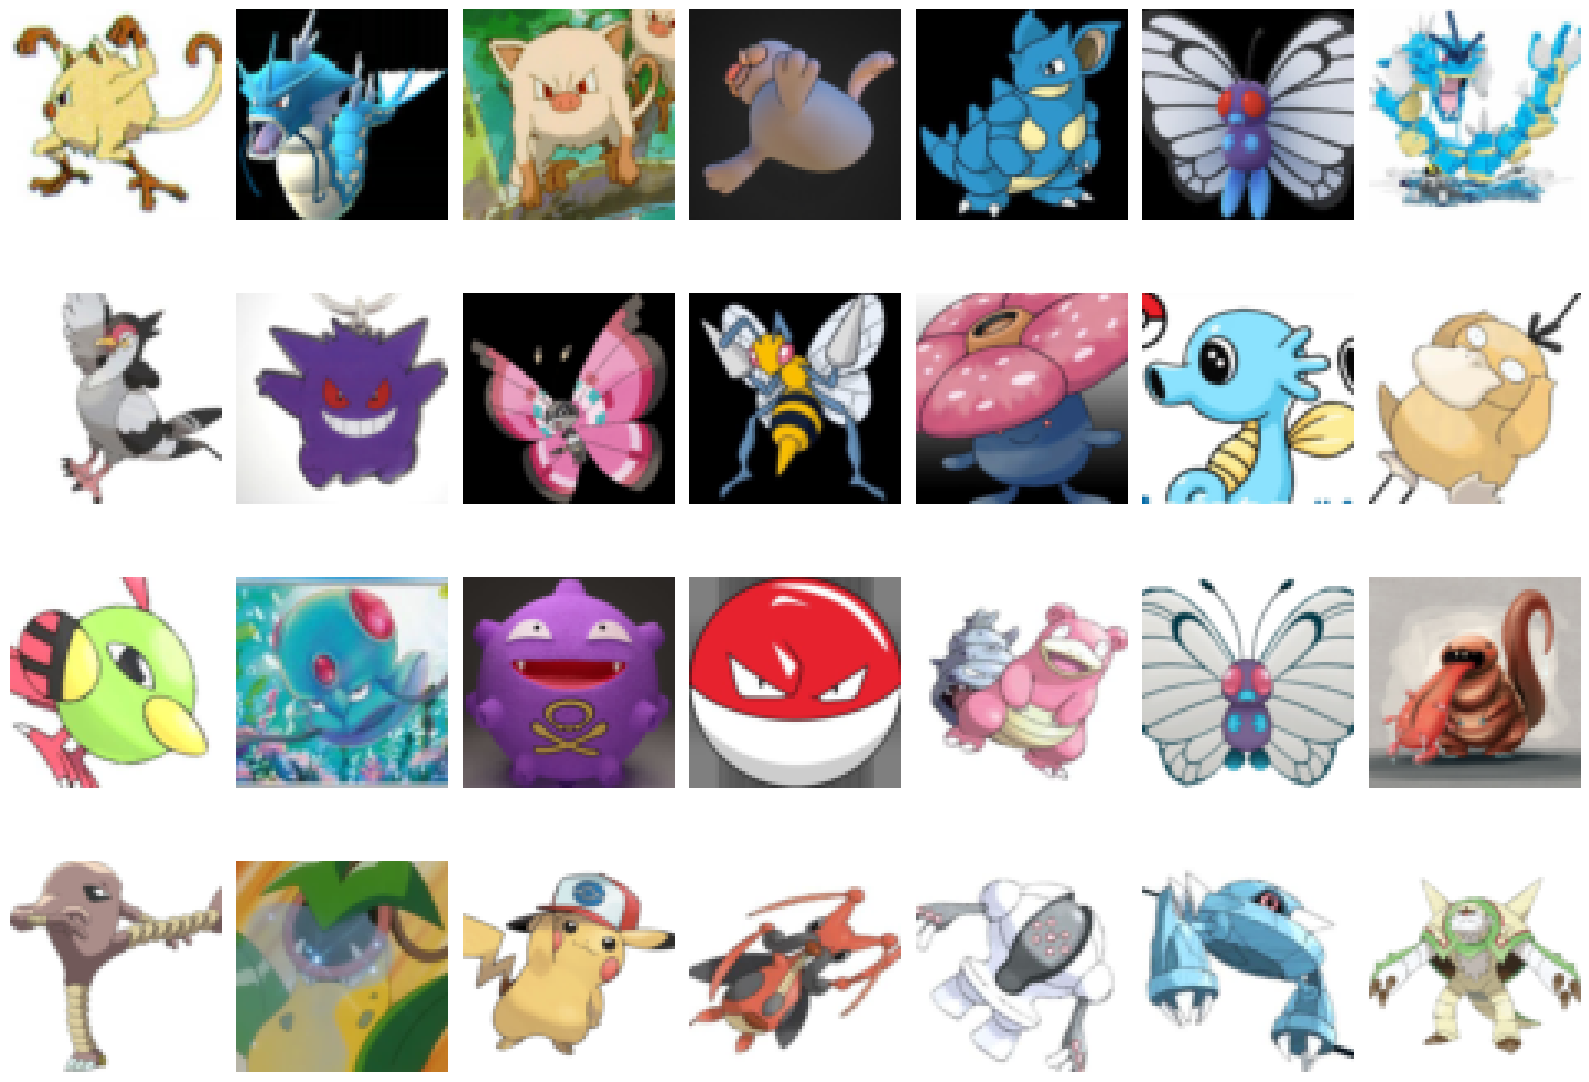

In [ ]:
plt.figure(figsize=(16, 12))  # Adjust figure size for 4x7 grid

# Get a batch of images from the dataloader
images = next(iter(dataloader))

# Display up to 28 images (4x7) from the batch
for i in range(min(28, images.shape[0])):
    ax = plt.subplot(4, 7, i + 1)  # Create 4x7 grid
    image = images[i].permute(1, 2, 0).cpu()  # Move to CPU and permute
    image = (image + 1) / 2  # Denormalize to the range [0, 1]
    plt.imshow(image)  # Display the denormalized image
    plt.axis('off')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()  # Display the plot

### verifying our dataloader has taken in the pokemon dataset

In [ ]:
batch = next(iter(dataloader))
print(f"Batch shape: {batch.shape}")  # Should be [batch_size, 3, image_size, image_size]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch shape: torch.Size([128, 3, 64, 64])


## Build the GAN Architecture (DCGAN)


training parameters

In [ ]:
latent_dim = 100
lr = 0.0002  # Learning rate, very small as to make minimal information loss when jumping back and fourth on nodes in back prop and forward prop (in generator and discrminator)
beta1 = 0.5  # Adam hyperparameter for optimising
num_epochs = 10
start_epoch = 0
batch_size = 128
fixed_noise = torch.randn(64, 100, 1, 1) # 64: noise vectors each sample in batch, 100: size of the latent space (random noise input to the generator) and 1, 1: feature map with a single spatial pixel.
max_res = 256
init_res = 4
channels = 3 # RGB
checkpoint_interval = 4  # Save every 4 epochs , big data :0
resume_from_checkpoint = True  # Set to False for fresh start
loss_history = {'G': [], 'D': []}  #to share in every epoch
fixed_noise = torch.randn(64, 100, 1, 1)
alpha = 0.0  # fade-in factor , weighted sum
img_list = []  #animation visualiation later on
epoch = 0  # for atexit storing

## Progressive GAN growing mehcanism applied [** Bonus** ]

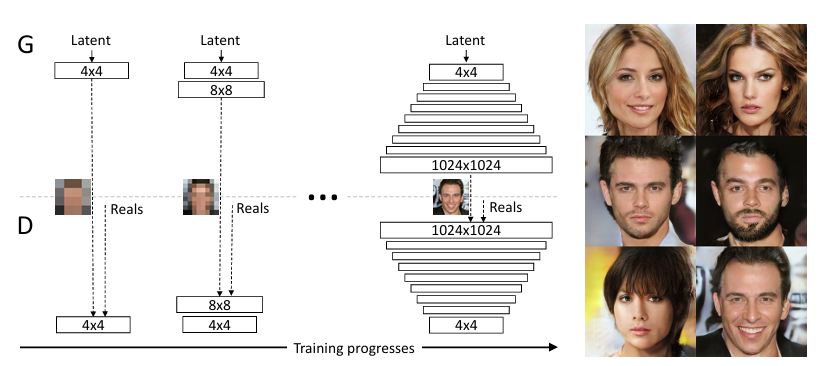

credit source: https://arxiv.org/pdf/1710.10196

The key idea is to start training with low-resolution images (e.g., 4x4) and gradually increase the resolution (e.g., 8x8, 16x16, ..., up to 1024x1024) by adding new layers to the generator and discriminator. This approach improves training stability and allows the model to generate high-quality images.
For our pokemon dataset we will start with 64x64 image and progressively learn to 28x128
References to material used to learn:

https://github.com/tkarras/progressive_growing_of_gans

https://www.youtube.com/watch?v=G06dEcZ-QTg


### Generator architecture

The progressive GAN (pGAN) below has input random noise (fixed dimension through pytorch) , it basically has a function that will add layera during training time, and take weighted sum of the weights to pass onto for the next epoch. The progressive learning and generating of pokemoni images will continue to 256 x 256  dimension resolution

keeping in mind that alpha is our weighted sum

In [ ]:
class Generator1(nn.Module):
    def __init__(self, latent_dim=latent_dim, channels=channels, max_resolution=max_res):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.max_resolution = max_resolution
        self.current_resolution = 4  # Start with 4x4
        self.layers = nn.ModuleList()
        self.to_rgb_layers = nn.ModuleList()

        # Input layer: latent_dim of 512x4x4 , 512 filters and 4x4 image resolution
        self.layers.append(nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ))
        self.to_rgb_layers.append(nn.Conv2d(512, channels, 1, 1, 0))  # 512x4x4 cnverts to 3x4x4

        # addition of the layers progressively
        self._add_layers()

    def _add_layers(self):
        resolutions = [8, 16, 32, 64, 128]  # resolutions to grow or advance to
        in_channels = 512
        out_channels = 512

        for res in resolutions:
            if res > self.max_resolution:
                break
                # this is one of the upsampling layers that go intermediate between a simple Sequential based GAN
            self.layers.append(nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            ))
            self.to_rgb_layers.append(nn.Conv2d(out_channels, self.channels, 1, 1, 0))
            in_channels = out_channels
            out_channels = max(out_channels // 2, 64)  # split learning channels in half as we upscale on the img resolution

    def forward(self, input, alpha=1.0, target_resolution=None): # cant fix teh target resolution since this is dynamiccally updating as per its own logic
        if target_resolution is None:
            target_resolution = self.current_resolution

        # Find the index of the target resolution
        res_index = int(torch.log2(torch.tensor(target_resolution))) - 2

        # Forward through layers up to the target resolution
        x = input.view(-1, self.latent_dim, 1, 1)
        for i in range(res_index + 1):
            x = self.layers[i](x)

        # Fade-in new layer (if alpha < 1.0)
        if alpha < 1.0 and res_index > 0:
            # getting the output from the previous resolution
            prev_x = self.layers[res_index - 1](input.view(-1, self.latent_dim, 1, 1))
            prev_rgb = self.to_rgb_layers[res_index - 1](prev_x)
            prev_rgb = F.interpolate(prev_rgb, scale_factor=2, mode='nearest')  # Upsample the image to current resolution

            # Get the output from the current resolution
            curr_rgb = self.to_rgb_layers[res_index](x)

            # phasing in the outputs as per paper terminology
            # converting the image feature x on 3 channels of rgb , interpolating them with prev.
            x = alpha * curr_rgb + (1 - alpha) * prev_rgb
        else:
            x = self.to_rgb_layers[res_index](x)

        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, channels=channels, max_resolution=max_res):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.max_resolution = max_resolution
        self.current_resolution = 4  # Start with 4x4
        self.layers = nn.ModuleList()
        self.to_rgb_layers = nn.ModuleList()

        # Initial layer: latent_dim -> 512x4x4
        self.layers.append(nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ))
        self.to_rgb_layers.append(nn.Conv2d(512, channels, 1, 1, 0))  # 512x4x4 -> 3x4x4

        # Add layers progressively
        self._add_layers()

    def _add_layers(self):
        resolutions = [8, 16, 32, 64, 128]  # Resolutions to grow into
        in_channels = 512
        out_channels = 512

        for res in resolutions:
            if res > self.max_resolution:
                break
            self.layers.append(nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            ))
            self.to_rgb_layers.append(nn.Conv2d(out_channels, self.channels, 1, 1, 0))
            in_channels = out_channels
            out_channels = max(out_channels // 2, 64)  # Halve channels as resolution increases

    def forward(self, input, alpha=1.0, target_resolution=None):
        if target_resolution is None:
            target_resolution = self.current_resolution

        # Find the index of the target resolution
        res_index = int(torch.log2(torch.tensor(target_resolution))) - 2

        # Forward through layers up to the target resolution
        x = input.view(-1, self.latent_dim, 1, 1)
        for i in range(res_index + 1):
            x = self.layers[i](x)

        # Fade-in new layer (if alpha < 1.0)
        if alpha < 1.0 and res_index > 0:
            # Get the output from the previous resolution
            prev_x = self.layers[res_index - 1](input.view(-1, self.latent_dim, 1, 1))
            prev_rgb = self.to_rgb_layers[res_index - 1](prev_x)
            prev_rgb = F.interpolate(prev_rgb, scale_factor=2, mode='nearest')  # Upsample to current resolution

            # Get the output from the current resolution
            curr_rgb = self.to_rgb_layers[res_index](x)

            # Blend the outputs
            x = alpha * curr_rgb + (1 - alpha) * prev_rgb
        else:
            x = self.to_rgb_layers[res_index](x)

        return x

### Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels=3, max_resolution=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.max_resolution = max_resolution
        self.current_resolution = 4  # Start with 4x4
        self.layers = nn.ModuleList()
        self.from_rgb_layers = nn.ModuleList()

        # Add layers progressively
        self._add_layers()

    def _add_layers(self):
        resolutions = [128, 64, 32, 16, 8, 4]  # Resolutions to grow into (reverse order)
        in_channels = 64
        out_channels = 128

        for res in resolutions:
            if res > self.max_resolution:
                continue
            self.from_rgb_layers.append(nn.Conv2d(self.channels, in_channels, 1, 1, 0))  # 3xNxN -> in_channelsxNxN
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            ))
            in_channels = out_channels
            out_channels = min(out_channels * 2, 512)  # Double channels as resolution decreases

        # Final layer: 512x4x4 -> 1
        self.final_layer = nn.Conv2d(512, 1, 4, 1, 0)

    def forward(self, input, alpha=1.0, target_resolution=None):
        if target_resolution is None:
            target_resolution = self.current_resolution

        # Find the index of the target resolution
        res_index = int(torch.log2(torch.tensor(target_resolution))) - 2

        # Fade-in new layer (if alpha < 1.0)
        if alpha < 1.0 and res_index > 0:
            # Downsample input to previous resolution
            prev_input = F.interpolate(input, scale_factor=0.5, mode='bilinear')
            prev_input = self.from_rgb_layers[res_index - 1](prev_input)
            prev_input = self.layers[res_index - 1](prev_input)

            # Process input at current resolution
            curr_input = self.from_rgb_layers[res_index](input)
            curr_input = self.layers[res_index](curr_input)

            # Blend the outputs
            x = alpha * curr_input + (1 - alpha) * prev_input
        else:
            x = self.from_rgb_layers[res_index](input)
            x = self.layers[res_index](x)

        # Forward through remaining layers
        for i in range(res_index + 1, len(self.layers)):
            x = self.layers[i](x)

        # Final layer
        x = self.final_layer(x)
        return x.view(-1)

In [ ]:
class Discriminator1(nn.Module):
    def __init__(self, channels=channels, max_resolution= max_res):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.max_resolution = max_resolution
        self.current_resolution = 4 # initial res that we are working with
        self.layers = nn.ModuleList()
        self.from_rgb_layers = nn.ModuleList()

        # dynamically adding the layers
        self._add_layers()

    def _add_layers(self):
        resolutions = [128, 64, 32, 16, 8, 4]  # resolutions to grow into (reverse order)
        in_channels = 64
        out_channels = 128

        for res in resolutions:
            if res > self.max_resolution:
                continue
            self.from_rgb_layers.append(nn.Conv2d(self.channels, in_channels, 1, 1, 0))  # 3xNxN : in_channelsxNxN res
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            ))
            in_channels = out_channels
            out_channels = min(out_channels * 2, 512)  # Double channels as resolution decreases

        # Final layer: 512x4x4 -> 1
        self.final_layer = nn.Conv2d(512, 1, 4, 1, 0)

    def forward(self, input, alpha=1.0, target_resolution=None):
        if target_resolution is None:
            target_resolution = self.current_resolution
              # In your discriminator's forward method
        print(f"Current resolution {target_resolution}, curr_input shape: {curr_input.shape}")
        print(f"Current resolution {target_resolution}, prev_input shape: {prev_input.shape}")

        # Finding the target resolution (next after 4, 16, 32, 64, 128 and finally 256) resolution
        res_index = int(torch.log2(torch.tensor(target_resolution))) - 2

        # slowly introduce a new layer (if alpha < 1.0)
        if alpha < 1.0 and res_index > 0:
            # Downsample input to previous resolution
            prev_input = F.interpolate(input, scale_factor=0.5, mode='bilinear')
            prev_input = self.from_rgb_layers[res_index - 1](prev_input)
            prev_input = self.layers[res_index - 1](prev_input)

            # "discrminating" input at current resolution of the progressive gan, since it is not static
            curr_input = self.from_rgb_layers[res_index](input)
            curr_input = self.layers[res_index](curr_input)

            # Blend the outputs
            x = alpha * curr_input + (1 - alpha) * prev_input
        else:
            x = self.from_rgb_layers[res_index](input)
            x = self.layers[res_index](x)

        # parsing through remaining layers (since its not sequential approach, we need this function)
        for i in range(res_index + 1, len(self.layers)):
            x = self.layers[i](x)

        # output layer
        x = self.final_layer(x)
        return x.view(-1)

### weights initialisation

In [ ]:
# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### applying weights to the generator and dsicrminator

In [ ]:
# Initialize our gen and disc neural network models
netG = Generator()
netD = Discriminator()
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3-5): 3 x Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### optimisers


In [ ]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

### checkpoint function

since i dont have  amighty beefy gpu , we have to enstate a failsafe for our model training, wihch are checkpoints, they shall save on a set interval all teh data needed to continue the progressive gan training with the saved weights, alpha and statistics (loss, mse etc)

In [ ]:
def save_checkpoint(epoch, generator, discriminator, optimizerG, optimizerD, losses, checkpoint_dir=checkpoint):
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_path = os.path.join(checkpoint_dir, f"gan_checkpoint_epoch_{epoch}.pth")

    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'losses': losses,
        'fixed_noise': fixed_noise,  # for consistent sample generation
        'current_resolution': current_resolution,  # Save current resolution
        'alpha': alpha  # saving weighted sum which gives the fade-in factor
    }, checkpoint_path)

    print(f"Checkpoint saved at epoch {epoch}")

# loading all the variables and parameters from previous known state
def load_checkpoint(checkpoint_path, generator, discriminator, optimizerG, optimizerD):
    checkpoint = torch.load(checkpoint_path)

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

    epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    fixed_noise = checkpoint['fixed_noise']
    current_resolution = checkpoint['current_resolution']
    alpha = checkpoint['alpha']

    print(f"Resuming training from epoch {epoch+1}, Resolution: {current_resolution}x{current_resolution}, Alpha: {alpha:.2f}")
    return epoch, losses, fixed_noise, current_resolution, alpha

## Training loop functon

In [ ]:
# continue the training if checkpoint exists
if resume_from_checkpoint:
    try:
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("PokemonDcgan_checkpoints")]
        if checkpoint_files:
            latest_checkpoint = sorted(checkpoint_files)[-1]
            start_epoch, loss_history, fixed_noise, current_resolution, alpha = load_checkpoint(
                os.path.join(checkpoint_dir, latest_checkpoint),
                netG, netD, optimizerG, optimizerD
            )
            start_epoch += 1  # begin back processing from next epoch
    except FileNotFoundError:
        print("No checkpoint found, starting fresh")

current_resolution = init_res  # Initialize with the starting resolution

# Training loop with progressive growth
def train_progressive_gan(generator, discriminator, dataloader, num_epochs=num_epochs, start_resolution=init_res, max_resolution=max_res):
    global current_resolution, alpha,img_list

    for epoch in range(start_epoch, num_epochs):
        for i, real_images in enumerate(dataloader): # Added enumerate to get batch index 'i'

            # adjustment point of resolution and alpha
            if current_resolution < max_resolution and epoch % 2 == 0:  # increase resolution every 10 epochs
                current_resolution *= 2
                alpha = 0.0  # Start fading in new layer
                # Adjust discriminator architecture to handle new resolution if needed
                # For example, you might add new layers or modify existing layers

            # Fade-in the new layer
            alpha = min(alpha + 0.1, 1.0)  # Gradually increase alpha

            # Adversarial ground truths
            real_labels = torch.full((batch_size,), 1.0)
            fake_labels = torch.full((batch_size,), 0.0)

            # Training itme

            #####################################################

            # DISCRMINATOR

            discriminator.zero_grad()

            # Real images
            outputs_real = discriminator(real_images, alpha=alpha, target_resolution=current_resolution) # Pass alpha and target_resolution
            loss_real = criterion(outputs_real, real_labels)

            # Fake images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=real_images.device) # Move noise to the device
            fake_images = generator(noise, alpha=alpha, target_resolution=current_resolution) # Pass alpha and target_resolution
            outputs_fake = discriminator(fake_images.detach(), alpha=alpha, target_resolution=current_resolution) # Pass alpha and target_resolution
            loss_fake = criterion(outputs_fake, fake_labels)

            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizerD.step()

            ##################################################

            # GENERATOR TRAIING

            generator.zero_grad()

            # Generate fake images and try to fool D
            outputs = discriminator(fake_images, alpha=alpha, target_resolution=current_resolution) # Pass alpha and target_resolution
            loss_G = criterion(outputs, real_labels)  # Trick D into thinking these are real , using binary cross entropy defined in criterion

            loss_G.backward()
            optimizerG.step()

            ####################################################

        # output training statistics
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")


        # Saving "fake" pokemon generated images
        if epoch % 5 == 0:
            with torch.no_grad():
                fake = generator(fixed_noise, alpha=alpha, target_resolution=current_resolution).detach()
                img_list.append(fake)  # storing for animation
                save_image(fake, f"pokepgan_{epoch}.png", normalize=True)

        # store checkpoints checkpoints
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(epoch, generator, discriminator, optimizerG, optimizerD, loss_history)

        # Emergency save every 30 minutes (adjust based on epoch duration)
        if time.time() - last_save_time > 1800:  # 30 minutes
            save_checkpoint(epoch, generator, discriminator, optimizerG, optimizerD, loss_history)
            last_save_time = time.time()

        print(f"Epoch [{epoch+1}/{num_epochs}], Resolution: {current_resolution}x{current_resolution}, Alpha: {alpha:.2f}")

No checkpoint found, starting fresh


## Documenting result images (fake pokemon)

checkpoint saving

In [ ]:
# log checkpoint saving on exit
atexit.register(save_checkpoint, epoch, netG, netD, optimizerG, optimizerD, loss_history)

<function __main__.save_checkpoint(epoch, generator, discriminator, optimizerG, optimizerD, losses, checkpoint_dir='/content/drive/MyDrive/Gen ai A2/PokemonDcgan_checkpoints')>

## Training

In [ ]:
train_progressive_gan(netG, netD, dataloader, num_epochs=num_epochs, start_resolution=4, max_resolution=256)

RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 3

## Visualisations

In [ ]:
# plotting the loss metrics
plt.figure(figsize=(10, 5))
plt.plot(loss_history['G'], label="Generator Loss")
plt.plot(loss_history['D'], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Over Time")
plt.legend()
plt.show()

### Creating an animation of generated images

In [ ]:
fig = plt.figure(figsize=(20, 20))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i[0], (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [ ]:
# displaying the animation
HTML(ani.to_jshtml())